In [13]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
%matplotlib notebook
import importlib

In [14]:
df = pd.read_hdf('dataset/binance_data_train.h5', 'STW')
sample_len   = 480
obs_data_len = 192
step_len     = 1
n_action_intervals = 5
device = "cpu"

In [3]:
import DQNTradingAgent.dqn_agent as dqn_agent
from custom_hyperparameters import hyperparams
from envs.trading_env_integrated import TradingEnv

/home/jeffrey/Binanace_trading_simulation/agent/DQN/envs/trading_env_integrated.py:4: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/jeffrey/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/jeffrey/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jeffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/jeffrey/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jeffrey/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 

In [4]:
env_name = ["bollinger", "macd", "stochastic", "rsi"]

In [5]:
def load_agent_and_run(env_name, agent_num):
    load_location = 'saves/transfer/{}/{}'.format(env_name,agent_num)
    class args():
        def __init__(self, name):
            self.environment=name
    args = args(env_name)
    env = TradingEnv(custom_args=args, env_id='custom_trading_env', obs_data_len=obs_data_len, step_len=step_len, sample_len=sample_len,
                               df=df, fee=0.001, initial_budget=1, n_action_intervals=n_action_intervals, deal_col_name='c', sell_at_end=True,
                               feature_names=['o', 'h','l','c','v',
                                              'num_trades', 'taker_base_vol'])
    agent = dqn_agent.Agent(action_size=2 * n_action_intervals + 1, obs_len=obs_data_len, num_features=env.reset().shape[-1], **hyperparams)
    agent.qnetwork_local.load_state_dict(torch.load(os.path.join(load_location, 'TradingGym_Rainbow_400.pth'), map_location=device))
    agent.qnetwork_local.to(device)
    agent.qnetwork_local.eval()
    
    state = env.reset()
    while True:
        action = int(agent.act(state, eps=0.))
        next_state, reward, done, _ ,fee_rate= env.step(action)
        state = next_state
        if done:
            break
    return env.total_fee, env.total_volume

In [6]:
from tqdm import tqdm, tnrange

In [7]:
fee_table = {}
volume_table = {}

In [8]:
import time

In [9]:
for i in tnrange(len(env_name), desc= "env"):
    env = env_name[i]
    env_fee = 0.
    env_volume = 0.
    for agent_num in tnrange(1,31, desc=f"agent num"):
        fee, volume = load_agent_and_run(env,agent_num)
        env_fee+=fee
        env_volume+=volume
    fee_table[env] = env_fee
    volume_table[env] = env_volume

[2019-09-03 16:53:19,998] Making new env: custom_trading_env
/home/jeffrey/Binanace_trading_simulation/agent/DQN/envs/trading_env_integrated.py:108: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self.price = self.df_sample[self.price_name].as_matrix()
/home/jeffrey/Binanace_trading_simulation/agent/DQN/envs/trading_env_integrated.py:110: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self.obs_features = self.df_sample[self.using_feature].as_matrix()
[2019-09-03 16:55:38,849] Making new env: custom_trading_env
[2019-09-03 16:57:54,771] Making new env: custom_trading_env
[2019-09-03 17:00:20,829] Making new env: custom_trading_env
[2019-09-03 17:02:34,966] Making new env: custom_trading_env
[2019-09-03 17:04:53,129] Making new env: custom_trading_env
[2019-09-03 17:07:08,349] Making new env: custom_trading_env
[2019-09-03 17:09:37,749] Making new env: custom_trading_env
[2019-09-03 17:11:53,602] 

[2019-09-03 17:38:32,768] Making new env: custom_trading_env
[2019-09-03 17:39:41,049] Making new env: custom_trading_env
[2019-09-03 17:40:48,910] Making new env: custom_trading_env
[2019-09-03 17:41:56,506] Making new env: custom_trading_env
[2019-09-03 17:43:04,650] Making new env: custom_trading_env
[2019-09-03 17:44:13,668] Making new env: custom_trading_env
[2019-09-03 17:45:20,945] Making new env: custom_trading_env
[2019-09-03 17:46:29,435] Making new env: custom_trading_env
[2019-09-03 17:47:37,592] Making new env: custom_trading_env
[2019-09-03 17:48:46,189] Making new env: custom_trading_env
[2019-09-03 17:49:54,865] Making new env: custom_trading_env
[2019-09-03 17:51:03,068] Making new env: custom_trading_env
[2019-09-03 17:52:12,261] Making new env: custom_trading_env
[2019-09-03 17:53:20,751] Making new env: custom_trading_env
[2019-09-03 17:54:28,294] Making new env: custom_trading_env
[2019-09-03 17:55:36,323] Making new env: custom_trading_env
[2019-09-03 17:56:44,360

[2019-09-03 18:18:31,783] Making new env: custom_trading_env
[2019-09-03 18:20:20,119] Making new env: custom_trading_env
[2019-09-03 18:21:28,472] Making new env: custom_trading_env
[2019-09-03 18:22:37,595] Making new env: custom_trading_env
[2019-09-03 18:23:47,585] Making new env: custom_trading_env
[2019-09-03 18:24:56,001] Making new env: custom_trading_env
[2019-09-03 18:26:05,731] Making new env: custom_trading_env
[2019-09-03 18:27:16,265] Making new env: custom_trading_env
[2019-09-03 18:28:25,241] Making new env: custom_trading_env
[2019-09-03 18:29:35,944] Making new env: custom_trading_env
[2019-09-03 18:30:45,005] Making new env: custom_trading_env
[2019-09-03 18:34:11,978] Making new env: custom_trading_env
[2019-09-03 18:35:21,251] Making new env: custom_trading_env
[2019-09-03 18:36:29,724] Making new env: custom_trading_env
[2019-09-03 18:37:39,176] Making new env: custom_trading_env
[2019-09-03 18:38:48,904] Making new env: custom_trading_env
[2019-09-03 18:39:57,832

[2019-09-03 18:53:43,464] Making new env: custom_trading_env
[2019-09-03 18:54:53,943] Making new env: custom_trading_env
[2019-09-03 18:56:04,193] Making new env: custom_trading_env
[2019-09-03 18:57:14,958] Making new env: custom_trading_env
[2019-09-03 18:58:24,281] Making new env: custom_trading_env
[2019-09-03 18:59:35,448] Making new env: custom_trading_env
[2019-09-03 19:00:45,294] Making new env: custom_trading_env
[2019-09-03 19:01:56,495] Making new env: custom_trading_env
[2019-09-03 19:03:06,913] Making new env: custom_trading_env
[2019-09-03 19:04:17,495] Making new env: custom_trading_env
[2019-09-03 19:05:27,603] Making new env: custom_trading_env
[2019-09-03 19:06:38,044] Making new env: custom_trading_env
[2019-09-03 19:07:48,470] Making new env: custom_trading_env
[2019-09-03 19:08:59,000] Making new env: custom_trading_env
[2019-09-03 19:10:10,258] Making new env: custom_trading_env
[2019-09-03 19:11:20,375] Making new env: custom_trading_env
[2019-09-03 19:12:31,181

#load fee_table and volume_table
import pickle
with open('fee_table.pkl','rb') as f:
    fee_table_ = pickle.load(f)
with open('volume_table.pkl','rb') as f:
    volume_table_ = pickle.load(f)

fee_table = {**fee_table, **fee_table_}
fee_table

volume_table = {**volume_table, **volume_table_}
volume_table

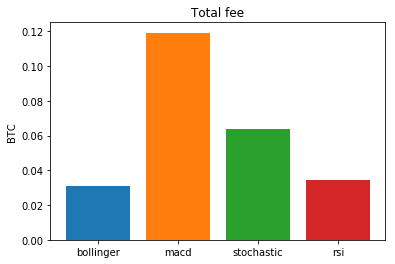

In [10]:
# compare plot
for env in env_name:
    plt.bar(x = env, height = fee_table[env])
plt.title("Total fee")
plt.ylabel("BTC")
plt.show()


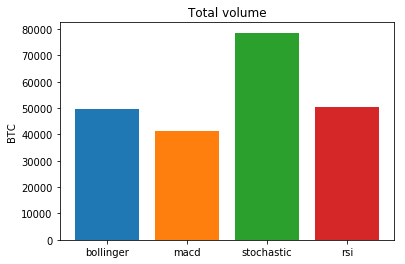

In [11]:
# compare plot
for env in env_name:
    plt.bar(x = env, height = volume_table[env])
plt.title("Total volume")
plt.ylabel("BTC")
plt.show()


<IPython.core.display.Javascript object>


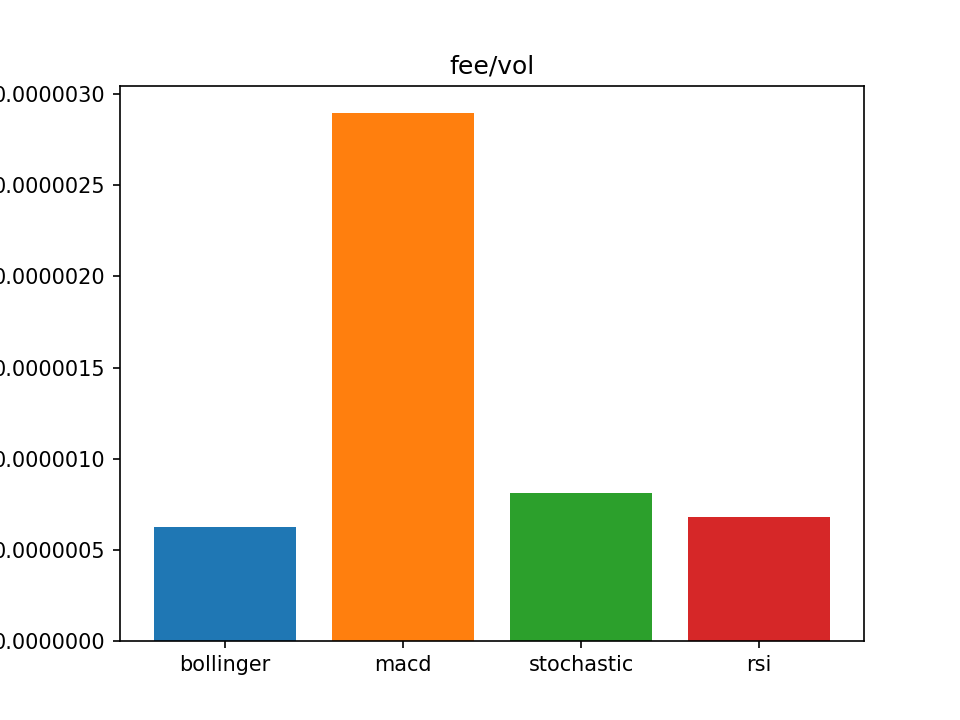

In [33]:
avg_fee_table=dict(zip(fee_table.keys(),np.array(list(fee_table.values()))/np.array(list(volume_table.values()))))
for env in env_name:
    plt.bar(x = env, height = avg_fee_table[env])
plt.title("fee/vol")
plt.ylabel("BTC")
plt.show()

In [12]:
# save
import pickle

with open("fee_table.pkl",'wb') as f:
    pickle.dump(fee_table, f)

with open("volume_table.pkl",'wb') as f:
    pickle.dump(volume_table, f)